In [ ]:
import ehrapy as ep
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

import warnings

warnings.filterwarnings("ignore")

In [3]:
adata = ep.dt.diabetes_130_fairlearn()
ep.ad.move_to_obs(adata, ["race", "gender", "age", "A1Cresult", "admission_source_id"], copy_obs=True)
adata.obs["A1Cresult_measured"] = ~adata.obs["A1Cresult"].isna()

❗ Features 'time_in_hospital', 'num_procedures', 'number_diagnoses', 'readmit_binary' were detected as categorical features stored numerically.Please verify and correct using `ep.ad.replace_feature_types` if necessary.
❗ Feature types were inferred and stored in adata.var[feature_type]. Please verify using `ep.ad.feature_type_overview` and adjust if necessary using `ep.ad.replace_feature_types`.


In [4]:
# pairwise chi-squared tests between the three groups
referral = adata.obs["A1Cresult_measured"][
    adata.obs["admission_source_id"] == "Referral"
]
emergency = adata.obs["A1Cresult_measured"][
    adata.obs["admission_source_id"] == "Emergency"
]
other = adata.obs["A1Cresult_measured"][adata.obs["admission_source_id"] == "Other"]

groups = [referral, emergency, other]
group_names = ["referral", "emergency", "other"]

# Perform pairwise comparisons
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        # Create contingency table
        observed = [
            [sum(groups[i]), len(groups[i]) - sum(groups[i])],
            [sum(groups[j]), len(groups[j]) - sum(groups[j])],
        ]

        # Perform chi-squared test
        chi2, p, dof, expected = chi2_contingency(observed)

        # Print results
        print(f"Comparison between Group {group_names[i]} and Group {group_names[j]}:")
        print("Chi-squared statistic:", chi2)
        print("p-value:", p)
        print("Degrees of freedom:", dof)
        print("Expected frequencies:")
        print(expected)
        print()

Comparison between Group referral and Group emergency:
Chi-squared statistic: 596.215773821687
p-value: 1.1140447707715962e-131
Degrees of freedom: 1
Expected frequencies:
[[ 5390.28301075 25465.71698925]
 [10043.71698925 47450.28301075]]

Comparison between Group referral and Group other:
Chi-squared statistic: 16.380265752052786
p-value: 5.182197620427166e-05
Degrees of freedom: 1
Expected frequencies:
[[ 3944.81749187 26911.18250813]
 [ 1715.18250813 11700.81749187]]

Comparison between Group emergency and Group other:
Chi-squared statistic: 460.0554308187645
p-value: 4.6755054166738994e-102
Degrees of freedom: 1
Expected frequencies:
[[10493.40499224 47000.59500776]
 [ 2448.59500776 10967.40499224]]



All groupwise comparisons are significant at the 0.001% level (Bonferroni Correction threshold considered for three tests: 0.001/3=0.00033)

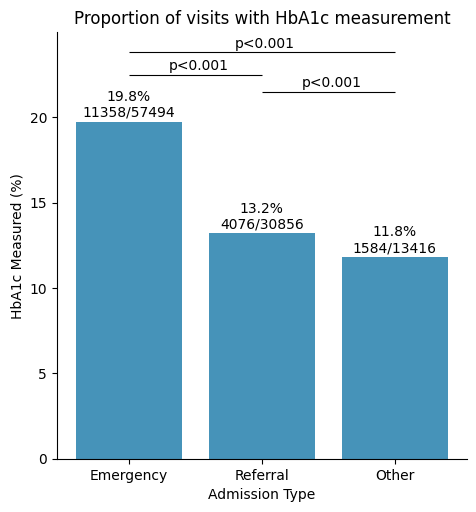

In [13]:
order = ["Emergency", "Referral", "Other"]
adata.obs["A1Cresult_measured_x100"] = adata.obs["A1Cresult_measured"] * 100
bar_plot = ep.pl.catplot(
    adata=adata,
    y="A1Cresult_measured_x100",
    x="admission_source_id",
    kind="bar",
    ci=False,
    order=order,
    palette=["#3399CC"],  # ehrapy palette
)


# Calculate the percentages
total = adata.obs.groupby('admission_source_id')['A1Cresult_measured_x100'].sum().reindex(order)
percentages = adata.obs.groupby('admission_source_id')['A1Cresult_measured_x100'].sum().reindex(order) / total.sum() * 100

# Calculate the total and true counts for each group
total_counts = adata.obs.groupby('admission_source_id')['A1Cresult_measured'].count().reindex(order)
true_counts = adata.obs.groupby('admission_source_id')['A1Cresult_measured'].sum().reindex(order)
percentages = (true_counts / total_counts) * 100

# Add percentages and counts on top of the bars
ax = bar_plot.facet_axis(0, 0)
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    height = p.get_height() + 0.1
    admission_source = int(p.get_x() + p.get_width() / 2 + 0.5)
    count_true = true_counts[admission_source]
    count_total = total_counts[admission_source]
    percentage = percentages[admission_source]
    ax.text(
        x,
        height,
        f'{percentage:.1f}%\n{count_true}/{count_total}',
        ha='center',
        va='bottom'
    )

plt.xlabel("Admission Type")
plt.ylabel("HbA1c Measured (%)")
plt.title("Proportion of visits with HbA1c measurement")
plt.text(1.3, 21.8, "p<0.001")
plt.text(0.3, 22.8, "p<0.001")
plt.text(0.8, 24.1, "p<0.001")
plt.hlines(21.5, 1, 2, colors="black", linewidth=0.8)
plt.hlines(22.5, 0, 1, colors="black", linewidth=0.8)
plt.hlines(23.8, 0, 2, colors="black", linewidth=0.8)

plt.savefig("surveillance_bias_barplot.png", dpi=300, bbox_inches="tight")
plt.show()